<a href="https://colab.research.google.com/github/patriani/RNN_LSTM_Tesla_stock/blob/main/ELT575_Semana3_ES119663.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import read_csv
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# Importando dados

Nesse problema de predição, usaremos um dataset público do github. Assim, usamos a função read_csv do pandas passando uma URL como caminho dos dados.
* Usaremos os últimos 20% dos pontos temporais como dados de teste

* Uma transformação Min-Max é usada apenas para colocar os dados numa escala [0,1]

In [ ]:
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
train_data, test_data, data = get_train_test(sunspots_url)

# Preparação dos dados

Para preparar os dados para a rede recorrente, devemos quebrar a série temporal em vetores de tamanho igual ao número de entradas da nossa rede (estamos considerando assim quantos time steps passados estamos usando para prever o time step atual)

In [ ]:
len(train_data)

2256

In [ ]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y

time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

# Construindo o modelo

Usaramos aqui uma rede recorrente simples com 3 unidades ocultas que utilizam 12 passos anteriores para estimar o atual estado. O resultado é avaliado por um único neurônio totalmente conectado que nos dá a saída da rede
* Função de ativação tanh em ambas as camadas da rede.

* Como função objetiva, usaremos o erro médio quadrático, já que estamos lidando com um problema de predição

In [ ]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                   activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1),
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=1, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
187/187 - 4s - 22ms/step - loss: 0.0259 - val_loss: 0.0446
Epoch 2/20
187/187 - 2s - 13ms/step - loss: 0.0116 - val_loss: 0.0252
Epoch 3/20
187/187 - 1s - 4ms/step - loss: 0.0064 - val_loss: 0.0164
Epoch 4/20
187/187 - 1s - 3ms/step - loss: 0.0050 - val_loss: 0.0150
Epoch 5/20
187/187 - 1s - 3ms/step - loss: 0.0048 - val_loss: 0.0135
Epoch 6/20
187/187 - 1s - 4ms/step - loss: 0.0046 - val_loss: 0.0131
Epoch 7/20
187/187 - 1s - 4ms/step - loss: 0.0045 - val_loss: 0.0122
Epoch 8/20
187/187 - 1s - 3ms/step - loss: 0.0044 - val_loss: 0.0116
Epoch 9/20
187/187 - 1s - 4ms/step - loss: 0.0044 - val_loss: 0.0116
Epoch 10/20
187/187 - 1s - 3ms/step - loss: 0.0043 - val_loss: 0.0109
Epoch 11/20
187/187 - 1s - 4ms/step - loss: 0.0043 - val_loss: 0.0111
Epoch 12/20
187/187 - 1s - 6ms/step - loss: 0.0042 - val_loss: 0.0106
Epoch 13/20
187/187 - 1s - 3ms/step - loss: 0.0043 - val_loss: 0.0100
Epoch 14/20
187/187 - 1s - 4ms/step - loss: 0.0041 - val_loss: 0.0100
Epoch 15/20
187/187 - 1s - 

## Avaliando o treinamento

Primeiro avaliamos o erro médio quadrático do conjunto de treino e de teste

In [ ]:
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Raíz do Erro Médio Quadrático para Treino: %.3f' % (train_rmse))
    print('Raíz do Erro Médio Quadrático para Teste: %.3f' % (test_rmse))

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Raíz do Erro Médio Quadrático para Treino: 0.062
Raíz do Erro Médio Quadrático para Teste: 0.093


Podemos também plotar como as nossas previsões se comparam com a série temporal original, como mostrado abaixo

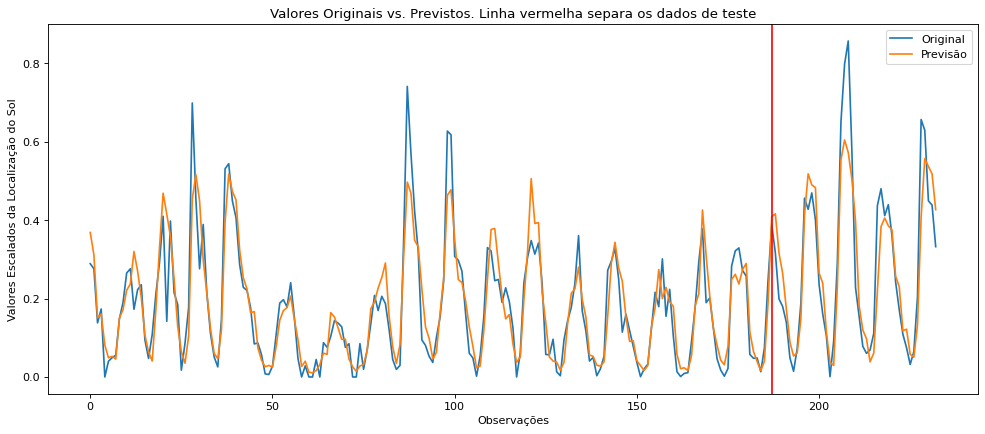

In [ ]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Original', 'Previsão'])
    plt.xlabel('Observações')
    plt.ylabel('Valores Escalados da Localização do Sol')
    plt.title('Valores Originais vs. Previstos. Linha vermelha separa os dados de teste')
plot_result(trainY, testY, train_predict, test_predict)